# LOAD

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import gc
import glob

import statsmodels.api as sm
import xgboost as xgb

from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor, as_completed

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler

pd.set_option('display.max_columns', None)
pl.Config.set_tbl_cols(None)

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

%matplotlib inline

In [2]:
%%time
train = pl.read_csv('train.csv', n_rows=125000, n_threads=4)
submission = pl.read_csv('sample_submission.csv', n_rows=1, n_threads=4).to_pandas()

CPU times: user 33.4 s, sys: 9.26 s, total: 42.7 s
Wall time: 16.1 s


# Functions

In [3]:
def r2_metric(preds, dtrain):
    labels = dtrain.get_label()
    r2 = r2_score(labels, preds)
    return 'r2', r2

In [4]:
def train_model_statsmodels(X, y):
    X = sm.add_constant(X)  # Adding a constant to the model
    model = sm.OLS(y, X).fit()
    return model

In [5]:
def fit_xgb_model(y_train, y_test, X_train, X_test):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    params = {
        'objective': 'reg:squarederror'
    }
    evals = [(dtest, 'eval')]
    model = xgb.train(params, dtrain, num_boost_round=1000, evals=evals, custom_metric=r2_metric)
    return model

In [6]:
def predict_chunk(chunk, models, pred_cols):
    ids = chunk['sample_id']
    chunk = chunk.drop(columns=['sample_id'])  # Remove the ID column for prediction
    predictions = np.zeros((len(chunk), len(submission.columns) - 1))
    for i, col in enumerate(pred_cols):
        dmatrix = xgb.DMatrix(chunk)
        preds = models[i].predict(dmatrix)
        predictions[:, submission.columns.get_loc(col) - 1] = preds
    return ids, predictions

In [7]:
def write_chunk_predictions(ids, chunk_predictions, file_path):
    chunk_df = pd.DataFrame(data=chunk_predictions, columns=submission.columns[1:])
    chunk_df.insert(0, 'sample_id', ids)
    chunk_df.to_csv(file_path, mode='a', header=not os.path.exists(file_path), index=False)
    del chunk_df

In [8]:
def process_in_parts(file_path, chunk_size, models, pred_cols, output_file):
    total_rows = sum(1 for row in open(file_path)) - 1  # Subtract 1 for header
    for start_row in range(0, total_rows, chunk_size):
        chunk = pd.read_csv(file_path, skiprows=range(1, start_row + 1), nrows=chunk_size)
        ids, chunk_predictions = predict_chunk(chunk, models, pred_cols)
        write_chunk_predictions(ids, chunk_predictions, output_file)
        del chunk, ids, chunk_predictions
        gc.collect()
        display('done!')

# Columns

In [9]:
# Target columns that have the weight 1
ptend_t = []
ptend_q0001 = []
ptend_q0002 = []
ptend_q0003 = []
ptend_u = []
ptend_v = []
cam_out_NETSW = []
cam_out_FLWDS = []
cam_out_PRECSC = []
cam_out_PRECC = []
cam_out_SOLS = []
cam_out_SOLL = []
cam_out_SOLSD = []
cam_out_SOLLD = []

In [10]:
# Train columns
state_t = []
state_u = []
state_v = []
state_q0001 = []
state_q0002 = []
state_q0003 = []
pbuf_ozone = []
pbuf_CH4 = []
pbuf_N2O = []
scalars = []

In [11]:
submission[submission['sample_id'] == 'test_0'].drop('sample_id', axis=1)

,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,ptend_t_10,ptend_t_11,ptend_t_12,ptend_t_13,ptend_t_14,ptend_t_15,ptend_t_16,ptend_t_17,ptend_t_18,ptend_t_19,ptend_t_20,ptend_t_21,ptend_t_22,ptend_t_23,ptend_t_24,ptend_t_25,ptend_t_26,ptend_t_27,ptend_t_28,ptend_t_29,ptend_t_30,ptend_t_31,ptend_t_32,ptend_t_33,ptend_t_34,ptend_t_35,ptend_t_36,ptend_t_37,ptend_t_38,ptend_t_39,ptend_t_40,ptend_t_41,ptend_t_42,ptend_t_43,ptend_t_44,ptend_t_45,ptend_t_46,ptend_t_47,ptend_t_48,ptend_t_49,ptend_t_50,ptend_t_51,ptend_t_52,ptend_t_53,ptend_t_54,ptend_t_55,ptend_t_56,ptend_t_57,ptend_t_58,ptend_t_59,ptend_q0001_0,ptend_q0001_1,ptend_q0001_2,ptend_q0001_3,ptend_q0001_4,ptend_q0001_5,ptend_q0001_6,ptend_q0001_7,ptend_q0001_8,ptend_q0001_9,ptend_q0001_10,ptend_q0001_11,ptend_q0001_12,ptend_q0001_13,ptend_q0001_14,ptend_q0001_15,ptend_q0001_16,ptend_q0001_17,ptend_q0001_18,ptend_q0001_19,ptend_q0001_20,ptend_q0001_21,ptend_q0001_22,ptend_q0001_23,ptend_q0001_24,ptend_q0001_25,ptend_q0001_26,ptend_q0001_27,ptend_q0001_28,ptend_q0001_29,ptend_q0001_30,ptend_q0001_31,ptend_q0001_32,ptend_q0001_33,ptend_q0001_34,ptend_q0001_35,ptend_q0001_36,ptend_q0001_37,ptend_q0001_38,ptend_q0001_39,ptend_q0001_40,ptend_q0001_41,ptend_q0001_42,ptend_q0001_43,ptend_q0001_44,ptend_q0001_45,ptend_q0001_46,ptend_q0001_47,ptend_q0001_48,ptend_q0001_49,ptend_q0001_50,ptend_q0001_51,ptend_q0001_52,ptend_q0001_53,ptend_q0001_54,ptend_q0001_55,ptend_q0001_56,ptend_q0001_57,ptend_q0001_58,ptend_q0001_59,ptend_q0002_0,ptend_q0002_1,ptend_q0002_2,ptend_q0002_3,ptend_q0002_4,ptend_q0002_5,ptend_q0002_6,ptend_q0002_7,ptend_q0002_8,ptend_q0002_9,ptend_q0002_10,ptend_q0002_11,ptend_q0002_12,ptend_q0002_13,ptend_q0002_14,ptend_q0002_15,ptend_q0002_16,ptend_q0002_17,ptend_q0002_18,ptend_q0002_19,ptend_q0002_20,ptend_q0002_21,ptend_q0002_22,ptend_q0002_23,ptend_q0002_24,ptend_q0002_25,ptend_q0002_26,ptend_q0002_27,ptend_q0002_28,ptend_q0002_29,ptend_q0002_30,ptend_q0002_31,ptend_q0002_32,ptend_q0002_33,ptend_q0002_34,ptend_q0002_35,ptend_q0002_36,ptend_q0002_37,ptend_q0002_38,ptend_q0002_39,ptend_q0002_40,ptend_q0002_41,ptend_q0002_42,ptend_q0002_43,ptend_q0002_44,ptend_q0002_45,ptend_q0002_46,ptend_q0002_47,ptend_q0002_48,ptend_q0002_49,ptend_q0002_50,ptend_q0002_51,ptend_q0002_52,ptend_q0002_53,ptend_q0002_54,ptend_q0002_55,ptend_q0002_56,ptend_q0002_57,ptend_q0002_58,ptend_q0002_59,ptend_q0003_0,ptend_q0003_1,ptend_q0003_2,ptend_q0003_3,ptend_q0003_4,ptend_q0003_5,ptend_q0003_6,ptend_q0003_7,ptend_q0003_8,ptend_q0003_9,ptend_q0003_10,ptend_q0003_11,ptend_q0003_12,ptend_q0003_13,ptend_q0003_14,ptend_q0003_15,ptend_q0003_16,ptend_q0003_17,ptend_q0003_18,ptend_q0003_19,ptend_q0003_20,ptend_q0003_21,ptend_q0003_22,ptend_q0003_23,ptend_q0003_24,ptend_q0003_25,ptend_q0003_26,ptend_q0003_27,ptend_q0003_28,ptend_q0003_29,ptend_q0003_30,ptend_q0003_31,ptend_q0003_32,ptend_q0003_33,ptend_q0003_34,ptend_q0003_35,ptend_q0003_36,ptend_q0003_37,ptend_q0003_38,ptend_q0003_39,ptend_q0003_40,ptend_q0003_41,ptend_q0003_42,ptend_q0003_43,ptend_q0003_44,ptend_q0003_45,ptend_q0003_46,ptend_q0003_47,ptend_q0003_48,ptend_q0003_49,ptend_q0003_50,ptend_q0003_51,ptend_q0003_52,ptend_q0003_53,ptend_q0003_54,ptend_q0003_55,ptend_q0003_56,ptend_q0003_57,ptend_q0003_58,ptend_q0003_59,ptend_u_0,ptend_u_1,ptend_u_2,ptend_u_3,ptend_u_4,ptend_u_5,ptend_u_6,ptend_u_7,ptend_u_8,ptend_u_9,ptend_u_10,ptend_u_11,ptend_u_12,ptend_u_13,ptend_u_14,ptend_u_15,ptend_u_16,ptend_u_17,ptend_u_18,ptend_u_19,ptend_u_20,ptend_u_21,ptend_u_22,ptend_u_23,ptend_u_24,ptend_u_25,ptend_u_26,ptend_u_27,ptend_u_28,ptend_u_29,ptend_u_30,ptend_u_31,ptend_u_32,ptend_u_33,ptend_u_34,ptend_u_35,ptend_u_36,ptend_u_37,ptend_u_38,ptend_u_39,ptend_u_40,ptend_u_41,ptend_u_42,ptend_u_43,ptend_u_44,ptend_u_45,ptend_u_46,ptend_u_47,ptend_u_48,ptend_u_49,ptend_u_50,ptend_u_51,ptend_u_52,ptend_u_53,ptend_u_54,ptend_u_55,ptend_u_56,ptend_u_57,ptend_u_58,ptend_u_59,ptend_v_0,ptend_v_1,ptend_v_2

In [12]:
zero_cols = []
pred_cols = []
cols = submission[submission['sample_id'] == 'test_0'].drop('sample_id', axis=1).columns
for col in cols:
    if submission[col].sum() != 0:
        pred_cols.append(col)
    else:
        zero_cols.append(col)

train_cols = train.drop(submission.columns).columns

small_cols = [col for col in train.columns if 'state_q0002' in col or 'state_q0003' in col or 'ptend_q0002' in col or 'ptend_q0003' in col]
reduce_mem_cols = train.drop(small_cols).columns

In [13]:
for col in pred_cols:
    if col[:7] == 'ptend_t':
        ptend_t.append(col)
    elif col[:7] == 'ptend_u':
        ptend_u.append(col)
    elif col[:7] == 'ptend_v':
        ptend_v.append(col)
    elif col[:11] == 'ptend_q0001':
        ptend_q0001.append(col)
    elif col[:11] == 'ptend_q0002':
        ptend_q0002.append(col)
    elif col[:11] == 'ptend_q0003':
        ptend_q0003.append(col)
    elif col[:13] == 'cam_out_NETSW':
        cam_out_NETSW.append(col)
    elif col == 'cam_out_FLWDS':
        cam_out_FLWDS.append(col)
    elif col == 'cam_out_PRECSC':
        cam_out_PRECSC.append(col)
    elif col == 'cam_out_PRECC':
        cam_out_PRECC.append(col)
    elif col == 'cam_out_SOLS':
        cam_out_SOLS.append(col)
    elif col == 'cam_out_SOLL':
        cam_out_SOLL.append(col)
    elif col == 'cam_out_SOLSD':
        cam_out_SOLSD.append(col)
    elif col == 'cam_out_SOLLD':
        cam_out_SOLLD.append(col)

In [14]:
len(ptend_t), len(ptend_q0001), len(ptend_q0002), len(ptend_q0003), len(ptend_u), len(ptend_v), len(cam_out_NETSW), len(cam_out_FLWDS), len(cam_out_PRECSC), len(cam_out_PRECC), len(cam_out_SOLS), len(cam_out_SOLL), len(cam_out_SOLSD), len(cam_out_SOLLD)

(60, 48, 48, 48, 48, 48, 1, 1, 1, 1, 1, 1, 1, 1)

In [15]:
for col in train_cols:
    if col[:7] == 'state_t':
        state_t.append(col)
    elif col[:7] == 'state_u':
        state_u.append(col)
    elif col[:7] == 'state_v':
        state_v.append(col)
    elif col[:11] == 'state_q0001':
        state_q0001.append(col)
    elif col[:11] == 'state_q0002':
        state_q0002.append(col)
    elif col[:11] == 'state_q0003':
        state_q0003.append(col)
    elif col[:10] == 'pbuf_ozone':
        pbuf_ozone.append(col)
    elif col[:8] == 'pbuf_CH4':
        pbuf_CH4.append(col)
    elif col[:8] == 'pbuf_N2O':
        pbuf_N2O.append(col)
    else:
        scalars.append(col)

In [16]:
assumption_test_1 = []
for col in train_cols:
    if col not in state_t[8:]:
        assumption_test_1.append(col)

# Feature Engineering

## EDA

In [17]:
# aesthetics
default_color_1 = 'darkblue'
default_color_2 = 'darkgreen'
default_color_3 = 'darkred'

### Properties of The Dataframe

In [18]:
train

sample_id,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,state_t_9,state_t_10,state_t_11,state_t_12,state_t_13,state_t_14,state_t_15,state_t_16,state_t_17,state_t_18,state_t_19,state_t_20,state_t_21,state_t_22,state_t_23,state_t_24,state_t_25,state_t_26,state_t_27,state_t_28,state_t_29,state_t_30,state_t_31,state_t_32,state_t_33,state_t_34,state_t_35,…,ptend_v_31,ptend_v_32,ptend_v_33,ptend_v_34,ptend_v_35,ptend_v_36,ptend_v_37,ptend_v_38,ptend_v_39,ptend_v_40,ptend_v_41,ptend_v_42,ptend_v_43,ptend_v_44,ptend_v_45,ptend_v_46,ptend_v_47,ptend_v_48,ptend_v_49,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""train_0""",213.806117,222.244454,229.259879,245.743959,258.337482,265.772467,263.978456,254.879872,243.946147,236.70699,230.934476,226.459626,222.014096,216.91297,210.688514,205.181518,201.649949,199.354256,196.582987,198.08732,200.30267,204.5107,209.294262,214.299322,219.180883,223.644692,227.899269,231.883467,235.859155,239.75449,243.663599,247.494148,251.145756,254.734832,258.118795,261.322883,…,6.3101e-7,3.8035e-7,2.6436e-8,-7.3957e-8,-1.0226e-7,-1.5508e-7,1.8131e-8,1.8428e-7,-1.9102e-8,1.8966e-7,-3.4925e-8,-2.5049e-7,-3.5119e-7,3.1814e-8,-0.000001,-0.000002,-7.6918e-7,-0.000007,-0.000007,-0.000021,-0.000008,0.000024,0.00002,0.000008,0.000003,2.1486e-7,-0.000001,-6.1321e-7,0.000001,0.0,349.564325,0.0,2.9477e-12,0.0,0.0,0.0,0.0
"""train_1""",213.17743,225.851064,229.663618,246.828333,261.026415,269.078431,267.736565,256.896227,244.169421,236.844423,231.586369,227.873491,224.125186,219.864133,214.768666,209.773682,206.593758,205.144601,202.21968,203.165579,203.691769,206.691885,210.018967,213.651746,217.22671,220.732834,224.271241,227.879259,231.523113,235.206556,238.911192,242.569836,246.095623,249.661886,253.170195,256.545214,…,2.3532e-7,-0.000002,4.7710e-7,-4.6249e-7,-4.7910e-7,3.4284e-7,1.5265e-7,-3.6109e-7,4.7664e-7,2.6672e-7,-1.8301e-7,-0.000001,-3.2145e-8,0.000002,-0.000002,-0.000005,-0.000006,-0.000002,-0.000009,-0.000015,-0.000008,0.000017,0.000023,0.000013,0.000004,7.6476e-7,-8.6454e-7,3.5609e-7,9.9849e-7,0.0,335.204086,0.0,3.1384e-9,0.0,0.0,0.0,0.0
"""train_2""",217.105685,220.448106,234.653398,244.422951,254.023818,259.651472,257.709514,251.064513,241.8796,234.487318,228.294373,223.660529,219.108751,214.820508,208.639566,201.055995,193.462408,190.267832,188.690119,189.957238,196.482059,203.461783,210.517854,217.264497,223.298206,228.871994,234.369621,239.208271,243.596733,247.688112,251.639426,255.233656,258.531051,261.569665,264.470169,267.068563,…,-0.000002,-6.3580e-7,-0.000001,-5.8939e-7,-6.8356e-7,1.3912e-7,-1.8613e-7,-3.5363e-7,5.9231e-7,-5.4433e-7,-4.1161e-7,-7.6074e-7,-3.6474e-7,5.2729e-7,0.000002,0.000006,0.000013,0.000012,0.000016,0.000005,-0.000005,-0.00002,-0.00004,-0.000035,-0.00002,-0.000013,-0.000004,0.000002,0.000062,0.0,401.70934,0.0,7.4242e-9,0.0,0.0,0.0,0.0
"""train_3""",217.773994,225.611775,234.104091,247.745365,257.411402,263.470947,261.131775,253.30325,242.316814,234.396266,227.95502,223.999858,219.658845,215.24492,210.214695,204.137721,196.509274,191.893671,189.929401,190.806367,196.69688,203.68075,210.684974,217.256992,223.168849,228.660408,233.845497,238.535216,242.74732,246.688901,250.429055,253.907015,257.260424,260.436627,263.363255,266.154815,…,-0.000002,-0.000002,-8.0713e-7,-7.1824e-8,-1.6555e-8,-1.6542e-7,3.0559e-7,1.8800e-8,-1.3640e-7,2.0172e-7,-2.4224e-7,2.5207e-7,0.000001,-7.9637e-8,0.000002,0.000005,0.000003,-0.000002,-0.000003,-0.000001,0.000004,0.000013,-0.000001,-0.000

In [19]:
%%time
train.describe()

CPU times: user 37.5 s, sys: 8.96 s, total: 46.5 s
Wall time: 15.5 s


statistic,sample_id,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,state_t_9,state_t_10,state_t_11,state_t_12,state_t_13,state_t_14,state_t_15,state_t_16,state_t_17,state_t_18,state_t_19,state_t_20,state_t_21,state_t_22,state_t_23,state_t_24,state_t_25,state_t_26,state_t_27,state_t_28,state_t_29,state_t_30,state_t_31,state_t_32,state_t_33,state_t_34,…,ptend_v_31,ptend_v_32,ptend_v_33,ptend_v_34,ptend_v_35,ptend_v_36,ptend_v_37,ptend_v_38,ptend_v_39,ptend_v_40,ptend_v_41,ptend_v_42,ptend_v_43,ptend_v_44,ptend_v_45,ptend_v_46,ptend_v_47,ptend_v_48,ptend_v_49,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""125000""",125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,…,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0,125000.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,216.88462,230.339071,239.50935,249.137122,257.301999,260.573495,256.8288,248.497374,238.958337,232.204771,226.725001,222.353061,218.293773,214.832648,211.121413,207.124036,202.722096,200.051881,199.233323,200.816255,203.063233,205.959417,209.431462,213.20159,217.025681,220.840232,224.562884,228.183402,231.682799,235.07644,238.364761,241.570907,244.694966,247.740232,250.696923,…,-3.7298e-9,-2.1348e-8,-1.2204e-8,-5.6715e-8,-1.9904e-7,-3.1095e-7,-4.7523e-7,-5.7944e-7,-6.3140e-7,-6.7492e-7,-7.7321e-7,-8.4856e-7,-9.4074e-7,-0.000001,-0.000001,-0.000001,-0.000001,-7.5625e-7,-1.2127e-8,9.2539e-7,0.000002,0.000003,0.000005,0.000005,0.000004,0.000002,-7.9918e-7,-6.8044e-7,-0.000002,163.257085,342.110334,3.2136e-9,2.9237e-8,63.438439,69.250434,34.492474,18.465148
"""std""",null,5.642542,8.79649,7.559891,5.976722,5.608623,7.138399,8.291112,8.108198,7.304153,6.779327,6.391493,6.190565,6.161821,6.390179,7.256792,8.971659,11.491329,13.015484,11.335176,9.202855,5.64311,3.231239,3.004557,4.385215,6.152398,7.737579,9.14801,10.314206,11.283804,12.056418,12.669348,13.123113,13.446885,13.657647,13.77919,…,0.000009,0.000008,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000008,0.000009,0.000009,0.00001,0.000011,0.000012,0.000013,0.000014,0.000015,0.000016,0.000017,0.000019,0.00002,0.000022,0.000025,0.000026,0.000027,0.000027,0.000025,0.000022,0.00003,255.009938,77.021863,8.0653e-9,8.1307e-8,113.101371,119.077136,46.901432,30.245423
"""min""","""train_0""",161.172605,184.841224,207.991598,216.637005,224.612114,224.161647,213.781956,205.330044,199.801016,194.719,192.101713,190.666526,190.685573,191.345976,192.23732,189.660028,176.324412,170.826556,176.52633,184.706116,192.38198,196.192745,196.250288,197.04819,197.305905,198.463378,198.678341,200.660923,203.905689,207.699272,209.798248,211.478895,213.271102,215.150624,217.095365,…,-0.000348,-0.000305,-

In [20]:
max(train.null_count().to_pandas().iloc[0, 1:].tolist())

0

### Univariate Analysis

#### Heating Tendency (ptend_t)

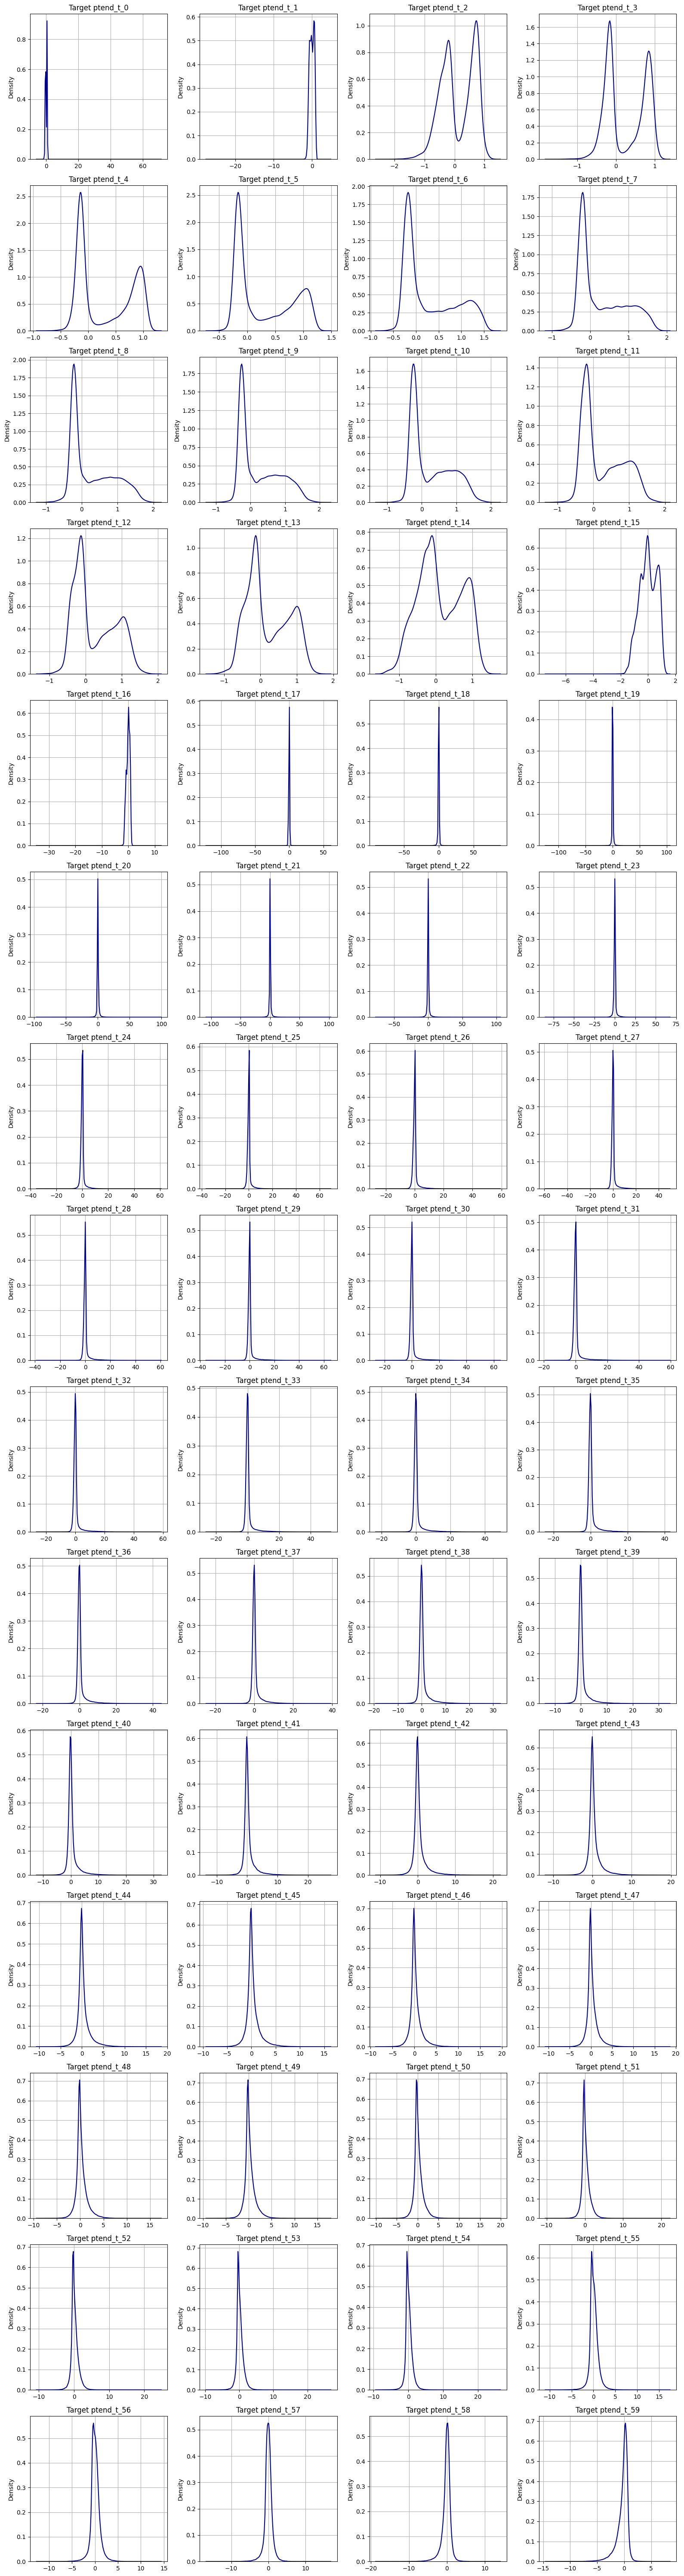

Elapsed time [m]:  1.0106


In [48]:
t1 = time.time()
fig, axs = plt.subplots(15, 4, figsize=(16,60))
i = 0
for t in ptend_t:
    current_ax = axs.flat[i]
    sns.kdeplot(train[t], ax=current_ax, color=default_color_1)
    current_ax.set_title(f'Target {str(t)}')
    current_ax.grid()
    i = i + 1

plt.tight_layout()
plt.show()
t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))

In [49]:
t1 = time.time()
c = train.to_pandas()
t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))

Elapsed time [m]:  3.7971


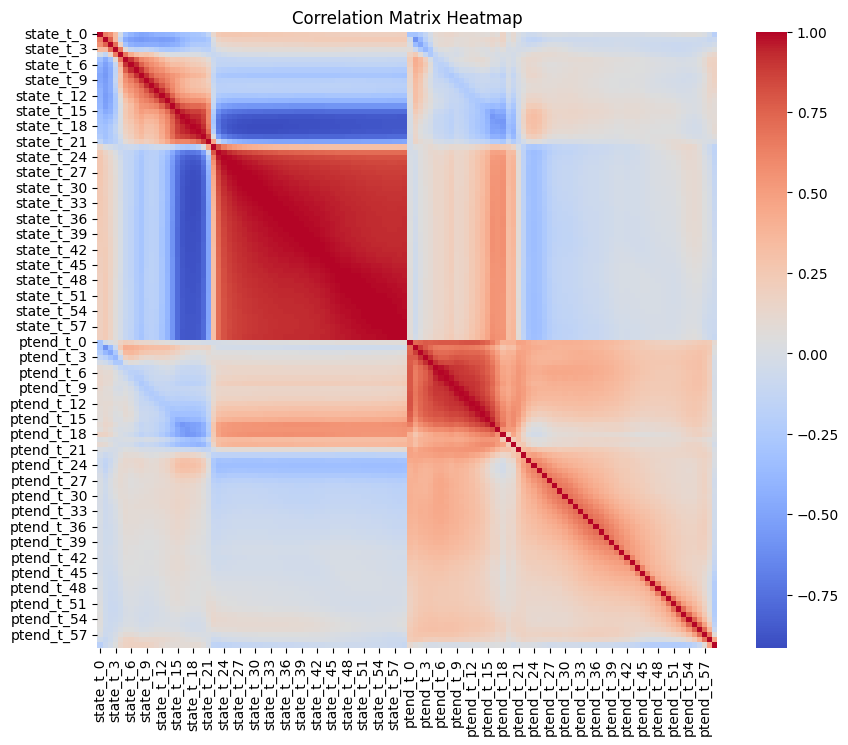

Elapsed time [m]:  0.8218


In [50]:
t1 = time.time()
# Pearson method for this one since air temperature has linear relationship with heating tendency
corr = c[state_t + ptend_t].corr(method='spearman', min_periods=2)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()
t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))

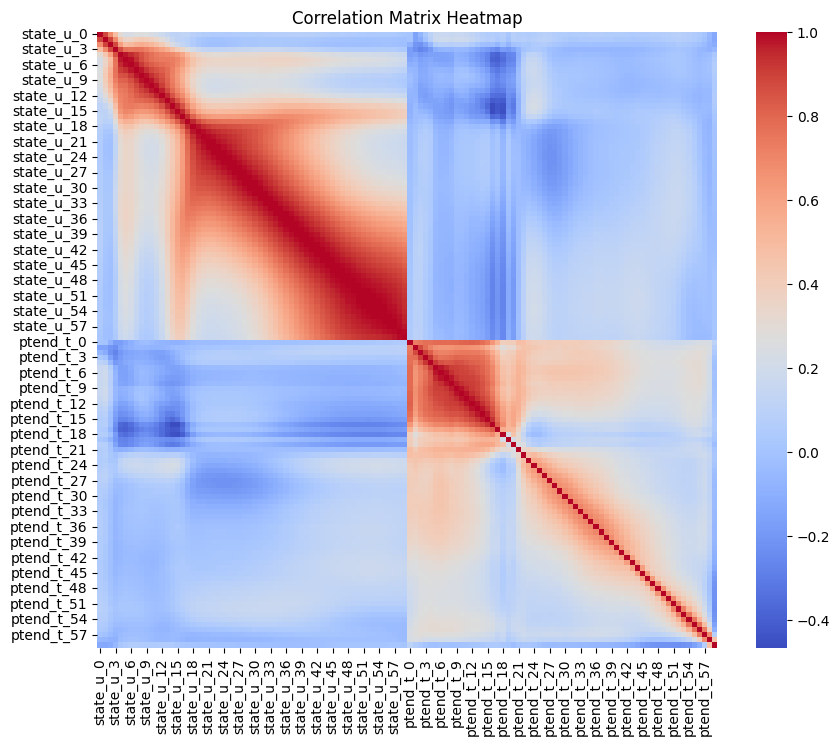

Elapsed time [m]:  0.4649


In [51]:
t1 = time.time()
corr = c[state_u + ptend_t].corr(method='spearman', min_periods=2)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()
t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))

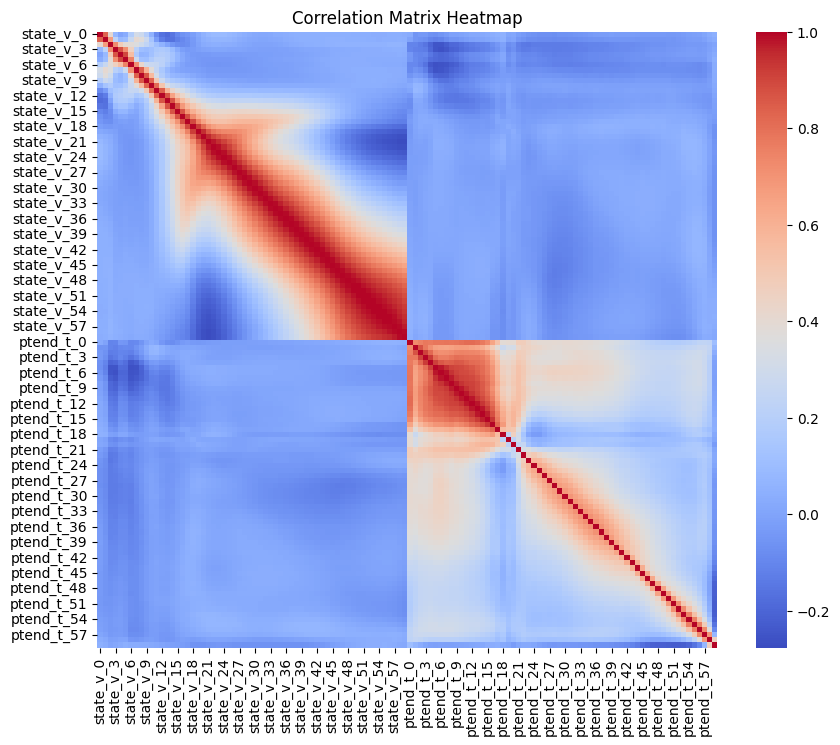

Elapsed time [m]:  0.4864


In [52]:
t1 = time.time()
corr = c[state_v + ptend_t].corr(method='spearman', min_periods=2)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()
t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))

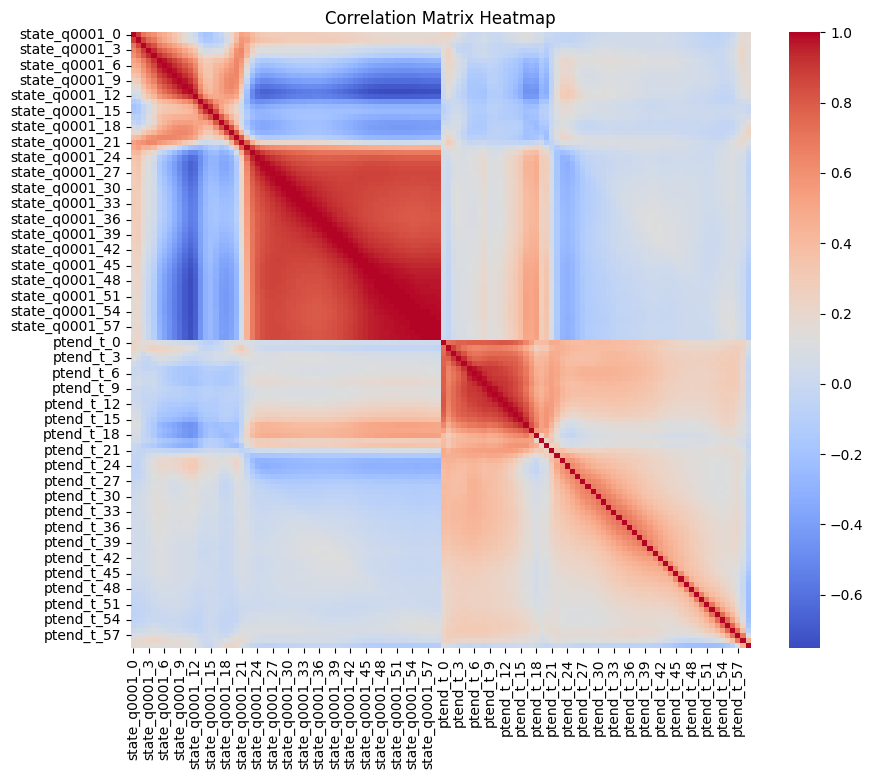

Elapsed time [m]:  0.4877


In [53]:
t1 = time.time()
corr = c[state_q0001 + ptend_t].corr(method='spearman', min_periods=2)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()
t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))

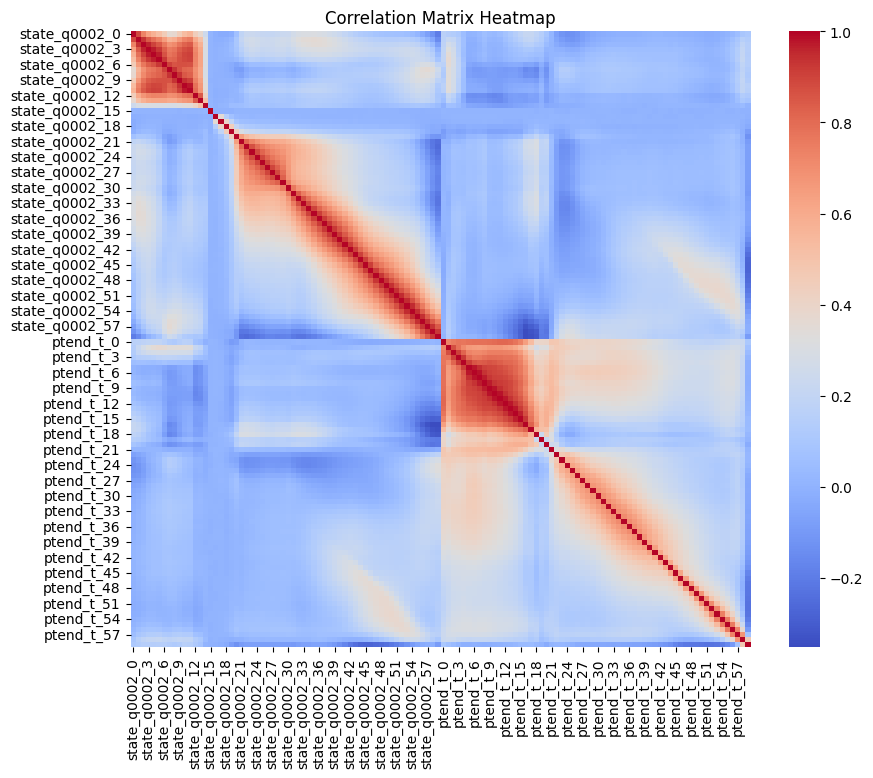

Elapsed time [m]:  0.4621


In [54]:
t1 = time.time()
corr = c[state_q0002 + ptend_t].corr(method='spearman', min_periods=2)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()
t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))

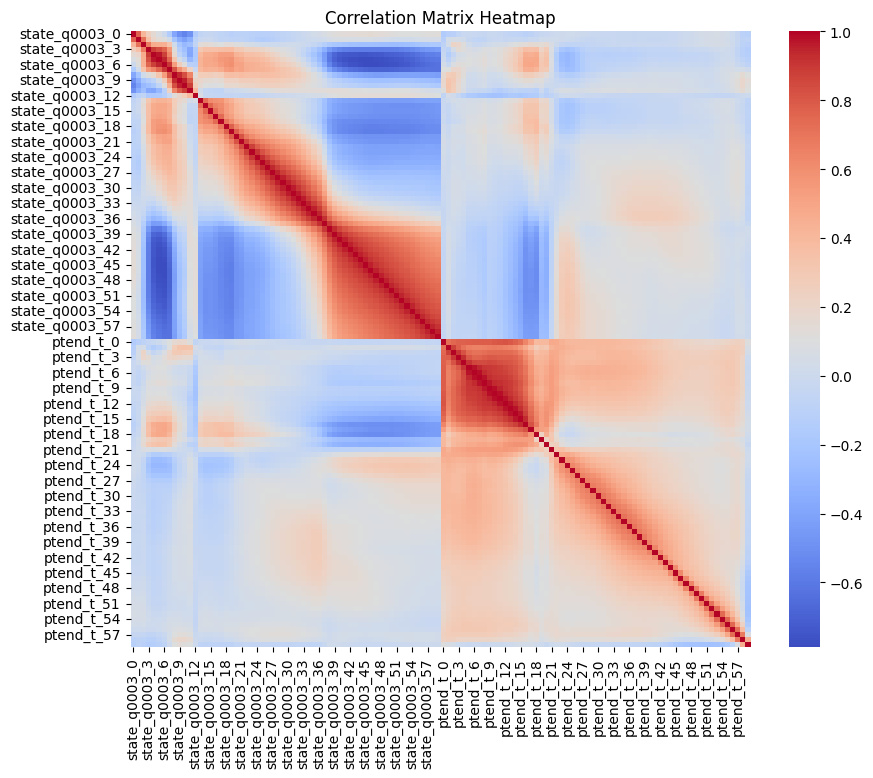

Elapsed time [m]:  0.4597


In [55]:
t1 = time.time()
corr = c[state_q0003 + ptend_t].corr(method='spearman', min_periods=2)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()
t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))

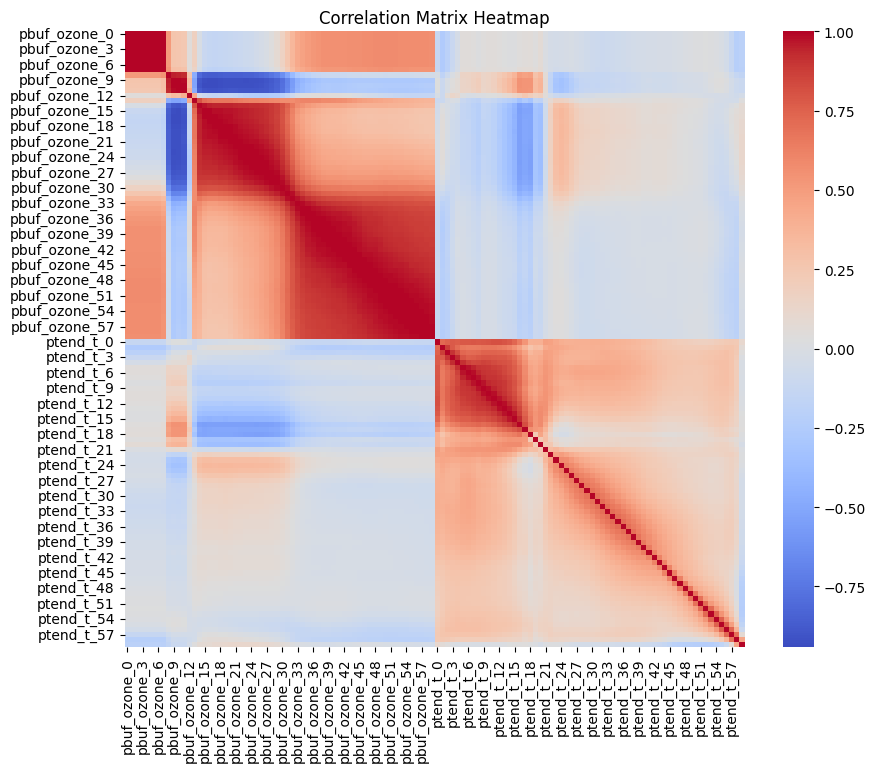

Elapsed time [m]:  0.5917


In [56]:
t1 = time.time()
corr = c[pbuf_ozone + ptend_t].corr(method='spearman', min_periods=2)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()
t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))

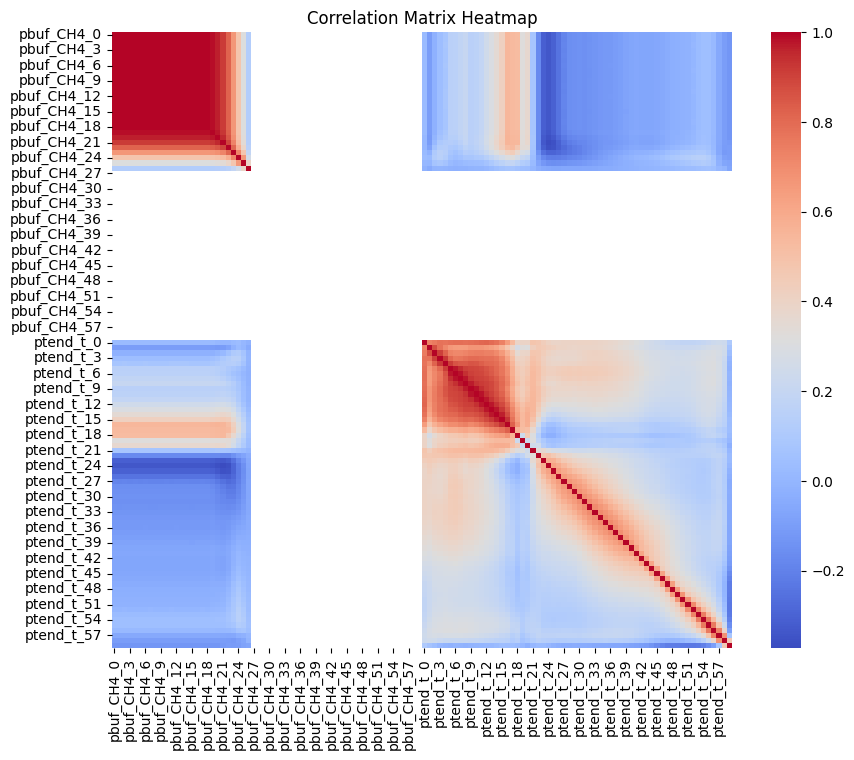

Elapsed time [m]:  0.4938


In [57]:
t1 = time.time()
corr = c[pbuf_CH4 + ptend_t].corr(method='spearman', min_periods=2)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()
t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))

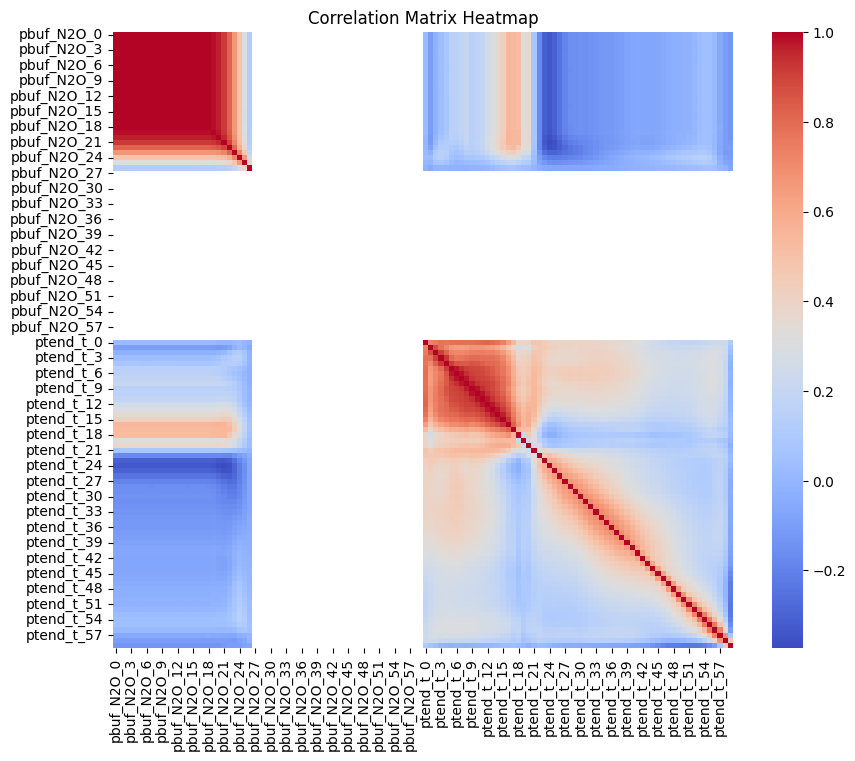

Elapsed time [m]:  0.5466


In [58]:
t1 = time.time()
corr = c[pbuf_N2O + ptend_t].corr(method='spearman', min_periods=2)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()
t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))

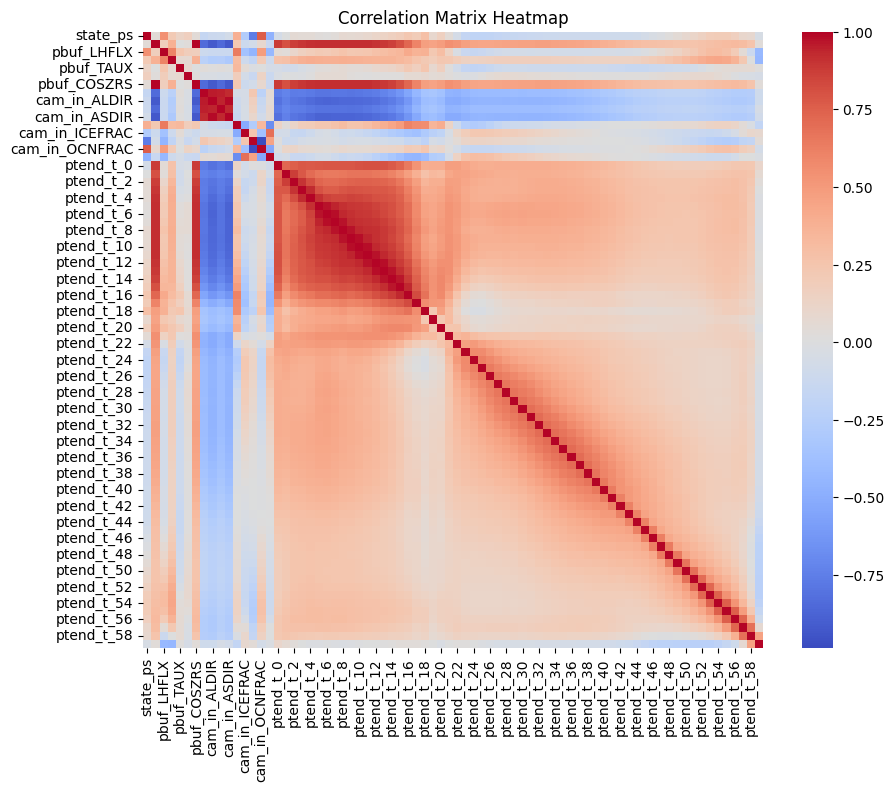

Elapsed time [m]:  0.1889


In [59]:
t1 = time.time()
corr = c[scalars + ptend_t].corr(method='spearman', min_periods=2)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()
t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))

In [60]:
t1 = time.time()
densities = {}
for k in range(60):
    density = []
    for i in range(125000):
        density.append((train['state_ps'][i]/101325)/(287 * train[f'state_t_{k}'][i]))
        #density2 = train['state_ps'][i]/(287 * train['state_t_0'][10])
    densities[f'density_{k}'] = [sum(density)/125000]

t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))

Elapsed time [m]:  0.8759


Elapsed time [m]:  0.0015


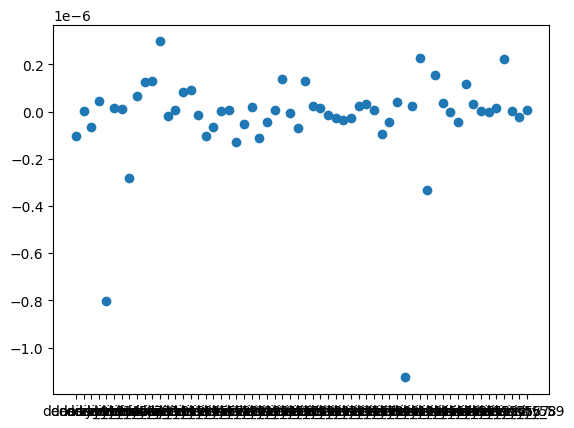

In [61]:
t1 = time.time()
plt.scatter(pd.DataFrame(densities).columns, pd.DataFrame(densities).iloc[0, :]) 
plt.show
t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))

In [62]:
p = train
p = p.with_columns(
    (train['state_ps'] / 101325).alias('p_atm')
)

In [63]:
p[state_q0001 + ['sample_id', 'p_atm']].sort('p_atm')

state_q0001_0,state_q0001_1,state_q0001_2,state_q0001_3,state_q0001_4,state_q0001_5,state_q0001_6,state_q0001_7,state_q0001_8,state_q0001_9,state_q0001_10,state_q0001_11,state_q0001_12,state_q0001_13,state_q0001_14,state_q0001_15,state_q0001_16,state_q0001_17,state_q0001_18,state_q0001_19,state_q0001_20,state_q0001_21,state_q0001_22,state_q0001_23,state_q0001_24,state_q0001_25,state_q0001_26,state_q0001_27,state_q0001_28,state_q0001_29,state_q0001_30,state_q0001_31,state_q0001_32,state_q0001_33,state_q0001_34,state_q0001_35,state_q0001_36,state_q0001_37,state_q0001_38,state_q0001_39,state_q0001_40,state_q0001_41,state_q0001_42,state_q0001_43,state_q0001_44,state_q0001_45,state_q0001_46,state_q0001_47,state_q0001_48,state_q0001_49,state_q0001_50,state_q0001_51,state_q0001_52,state_q0001_53,state_q0001_54,state_q0001_55,state_q0001_56,state_q0001_57,state_q0001_58,state_q0001_59,sample_id,p_atm
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
1.137414,1.631158,2.127917,1.810786,1.628077,1.401938,1.35532,1.354485,1.278156,1.070249,0.99802,1.092046,0.74697,0.004415,-0.187913,-0.067827,-0.045092,-0.04411,0.089401,0.602115,1.20776,0.827869,0.004152,-0.332381,-0.393324,-0.387969,-0.377445,-0.378643,-0.390154,-0.401343,-0.410769,-0.428521,-0.450466,-0.471937,-0.494699,-0.521586,-0.549269,-0.580153,-0.609361,-0.634617,-0.651268,-0.664914,-0.685606,-0.712716,-0.742581,-0.767387,-0.787006,-0.799384,-0.806945,-0.807901,-0.808003,-0.804643,-0.801557,-0.795346,-0.791634,-0.788373,-0.788734,-0.797158,-0.804654,-0.819423,"""train_75944""",-0.000072
1.129821,1.617236,2.086732,1.801064,1.628335,1.403865,1.357441,1.35459,1.276285,1.069212,1.003114,1.090769,0.710633,0.017097,-0.154399,0.000549,0.054169,0.035788,0.145213,0.634312,1.166484,0.775101,-0.000228,-0.326259,-0.391255,-0.386632,-0.377273,-0.378817,-0.390324,-0.400154,-0.407926,-0.424408,-0.446405,-0.468068,-0.493136,-0.519788,-0.546294,-0.577239,-0.608588,-0.635706,-0.652139,-0.664445,-0.681904,-0.712829,-0.742888,-0.767675,-0.787635,-0.799805,-0.807171,-0.807306,-0.807364,-0.805247,-0.802701,-0.796337,-0.792493,-0.78933,-0.789379,-0.796541,-0.804329,-0.816821,"""train_77864""",-0.000072
1.127349,1.665069,2.113706,1.802374,1.625756,1.402412,1.355899,1.350965,1.271334,1.06782,1.009381,1.084609,0.66031,0.038732,-0.113375,0.060684,0.130697,0.098544,0.212039,0.739181,1.198133,0.775689,0.025932,-0.294783,-0.371336,-0.376242,-0.370504,-0.373833,-0.386367,-0.397769,-0.405881,-0.422484,-0.443981,-0.466993,-0.491727,-0.520227,-0.547198,-0.579963,-0.612487,-0.639917,-0.656737,-0.669176,-0.686876,-0.712087,-0.741046,-0.766207,-0.785761,-0.797501,-0.806143,-0.808615,-0.810461,-0.809829,-0.806794,-0.799808,-0.795306,-0.792573,-0.792952,-0.800362,-0.807818,-0.813848,"""train_80936""",-0.000072
1.130708,1.649906,2.10448,1.806397,1.627584,1.402432,1.356031,1.352448,1.273762,1.068788,1.006284,1.089705,0.691986,0.025272,-0.137057,0.029726,0.093649,0.068512,0.179898,0.677363,1.171868,0.762721,0.001602,-0.320643,-0.387423,-0.384882,-0.376783,-0.378028,-0.388785,-0.398929,-0.406447,-0.423034,-0.44489,-0.46639,-0.491225,-0.518385,-0.545369,-0.577844,-0.610017,-0.637154,-0.65385,-0.666406,-0.683852,-0.708713,-0.737317,-0.761714,-0.782146,-0.799696,-0.80827,-0.808905,-0.809114,-0.807303,-0.804521,-0.7979,-0.793646,-0.790806,-0.79107,-0.79821,-0.805053,-0.819394,"""train_79016""",-0.000072
1.132946,1.662935,2.117604,1.807964,1.626439,1.401601,1.35516,1.351233,1.272356,1.068212,1.007404,1.089574,0.685775,0.031406,-0.128389,0.040581,0.10937,0.08135,0.188618,0.686527,1.169828,0.760636,0.007928,-0.312716,-0.38241,-0.382085,-0.37481,-0.376657,-0.388603,-0.398542,-0.406039,-0.42246,-0.444121,-0.46604,-0.490728,-0.519257,-0.546161,-0.578706,-0.611034,-0.638357,-0.655259,-0.667944,-0.685633,-0.710524,-0.739387,-0.764363,-0.78

In [64]:
p[state_t + ['sample_id', 'p_atm']].sort('p_atm')

state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,state_t_9,state_t_10,state_t_11,state_t_12,state_t_13,state_t_14,state_t_15,state_t_16,state_t_17,state_t_18,state_t_19,state_t_20,state_t_21,state_t_22,state_t_23,state_t_24,state_t_25,state_t_26,state_t_27,state_t_28,state_t_29,state_t_30,state_t_31,state_t_32,state_t_33,state_t_34,state_t_35,state_t_36,state_t_37,state_t_38,state_t_39,state_t_40,state_t_41,state_t_42,state_t_43,state_t_44,state_t_45,state_t_46,state_t_47,state_t_48,state_t_49,state_t_50,state_t_51,state_t_52,state_t_53,state_t_54,state_t_55,state_t_56,state_t_57,state_t_58,state_t_59,sample_id,p_atm
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
1.133098,0.118712,0.665631,1.403542,1.830849,1.118183,0.538311,0.700664,0.837127,0.810477,0.908994,1.072747,1.336454,1.635039,1.777621,1.555695,1.216409,1.050479,1.154244,1.102467,1.030596,0.455913,-1.122178,-1.298117,-1.210388,-1.171611,-1.161263,-1.174975,-1.19947,-1.22979,-1.26578,-1.309006,-1.355427,-1.409998,-1.462735,-1.515354,-1.563671,-1.614389,-1.658822,-1.69308,-1.712197,-1.731034,-1.742316,-1.75284,-1.761402,-1.776975,-1.790158,-1.809221,-1.828852,-1.854354,-1.88302,-1.915496,-1.950039,-1.985708,-2.027404,-2.066929,-2.104047,-2.194118,-2.300104,-2.629774,"""train_75944""",-0.000072
1.077894,0.142431,0.627059,1.365656,1.898089,1.260285,0.606596,0.718389,0.814808,0.777228,0.877453,1.04956,1.323517,1.62976,1.778651,1.560318,1.22268,1.060183,1.165164,1.118629,1.076055,0.564205,-0.981692,-1.231923,-1.171075,-1.145265,-1.142069,-1.160043,-1.187854,-1.221095,-1.259998,-1.306288,-1.355862,-1.41406,-1.470658,-1.526872,-1.578339,-1.631682,-1.677867,-1.713786,-1.73557,-1.75642,-1.769605,-1.777935,-1.786343,-1.801516,-1.813537,-1.831802,-1.849721,-1.873673,-1.899889,-1.92852,-1.959694,-1.992649,-2.032051,-2.075832,-2.11268,-2.187864,-2.295351,-2.530303,"""train_77864""",-0.000072
1.167994,0.200859,0.707147,1.418466,1.797054,1.064436,0.478967,0.635078,0.740342,0.686255,0.780089,0.960836,1.256832,1.580466,1.747946,1.543906,1.21546,1.058719,1.159613,1.110003,1.074393,0.600494,-0.912105,-1.195089,-1.148502,-1.131005,-1.133109,-1.154556,-1.185274,-1.221815,-1.264527,-1.315296,-1.369815,-1.433259,-1.495355,-1.556669,-1.612046,-1.667669,-1.71633,-1.756598,-1.783242,-1.8085,-1.827823,-1.844284,-1.85701,-1.876259,-1.883949,-1.89972,-1.913084,-1.93162,-1.951978,-1.974866,-2.002084,-2.032299,-2.068768,-2.11544,-2.155193,-2.230659,-2.351442,-2.465966,"""train_80936""",-0.000072
1.198632,0.155772,0.687084,1.406269,1.793608,1.077652,0.52019,0.68719,0.810664,0.763169,0.851182,1.018006,1.29599,1.606774,1.762398,1.55007,1.216828,1.057224,1.160795,1.113955,1.075881,0.582038,-0.949976,-1.215106,-1.160286,-1.138222,-1.137388,-1.156872,-1.185992,-1.220731,-1.261314,-1.309451,-1.361015,-1.421498,-1.480432,-1.539176,-1.592805,-1.647315,-1.694586,-1.733102,-1.75789,-1.781187,-1.797695,-1.810485,-1.818804,-1.831982,-1.841598,-1.85474,-1.870534,-1.893348,-1.918747,-1.946146,-1.976418,-2.008933,-2.047288,-2.093784,-2.130743,-2.205486,-2.301899,-2.593482,"""train_79016""",-0.000072
1.238216,0.08158,0.638585,1.357019,1.759499,1.026879,0.46001,0.629705,0.761103,0.72401,0.827772,1.006828,1.290863,1.603081,1.760347,1.550071,1.218513,1.060476,1.164256,1.117567,1.083889,0.600104,-0.926922,-1.204811,-1.154808,-1.135269,-1.135781,-1.156213,-1.186097,-1.221555,-1.262975,-1.312118,-1.364792,-1.426519,-1.486781,-1.546603,-1.60143,-1.656577,-1.704706,-1.744602,-1.770998,-1.796018,-1.814937,-1.830346,-1.840912,-1.857419,-1.865761,-1.881299,-1.894642,-1.913532,-1.934859,-1.959622,-1.988276,-2.02119,-2.058955,-2.105753,-2.144727,-2.21711,-2.31583,-2.594543,"""train_79784""",-0.000072
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…

In [65]:
p[ptend_t + ['sample_id', 'p_atm']].sort('p_atm')

ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,ptend_t_10,ptend_t_11,ptend_t_12,ptend_t_13,ptend_t_14,ptend_t_15,ptend_t_16,ptend_t_17,ptend_t_18,ptend_t_19,ptend_t_20,ptend_t_21,ptend_t_22,ptend_t_23,ptend_t_24,ptend_t_25,ptend_t_26,ptend_t_27,ptend_t_28,ptend_t_29,ptend_t_30,ptend_t_31,ptend_t_32,ptend_t_33,ptend_t_34,ptend_t_35,ptend_t_36,ptend_t_37,ptend_t_38,ptend_t_39,ptend_t_40,ptend_t_41,ptend_t_42,ptend_t_43,ptend_t_44,ptend_t_45,ptend_t_46,ptend_t_47,ptend_t_48,ptend_t_49,ptend_t_50,ptend_t_51,ptend_t_52,ptend_t_53,ptend_t_54,ptend_t_55,ptend_t_56,ptend_t_57,ptend_t_58,ptend_t_59,sample_id,p_atm
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
0.270296,0.429805,0.331651,0.376837,0.409883,0.362356,0.311068,0.281909,0.227114,0.170836,0.140514,0.118238,0.068493,-0.019854,-0.18119,-0.392705,-0.625315,-0.74174,-0.490343,-0.350108,-0.237824,0.159714,0.405815,0.510702,0.526607,0.499745,0.474084,0.450614,0.422475,0.40911,0.398558,0.389688,0.359108,0.308501,0.262841,0.231094,0.205033,0.173006,0.141175,0.12969,0.109003,0.08608,0.07934,0.049194,0.023456,-0.016255,-0.062051,-0.106049,-0.153635,-0.198872,-0.243882,-0.28929,-0.235479,-0.269759,-0.334766,-0.57627,-0.810567,-0.720808,-0.624659,1.268488,"""train_75944""",-0.000072
0.250492,0.367617,0.316728,0.354017,0.342768,0.24921,0.203161,0.192143,0.15775,0.112473,0.085414,0.064417,0.009023,-0.094302,-0.280514,-0.518819,-0.767287,-0.897599,-0.60264,-0.45611,-0.343805,0.039241,0.293354,0.424318,0.458716,0.442703,0.42316,0.402052,0.374086,0.357832,0.33974,0.325002,0.301364,0.263626,0.237319,0.200578,0.166088,0.137804,0.202863,0.1554,0.103974,0.045638,-0.012769,-0.032613,0.013059,-0.012712,-0.060946,-0.114345,-0.164226,-0.204725,-0.246704,-0.269598,-0.261088,-0.358091,-0.466564,-0.554945,-0.662759,-0.684867,-0.486647,0.592906,"""train_77864""",-0.000072
0.331734,0.428911,0.357477,0.410092,0.481232,0.500247,0.491818,0.445848,0.366873,0.293247,0.25726,0.233611,0.191899,0.12591,0.004246,-0.166914,-0.3844,-0.530955,-0.303997,-0.182927,-0.062313,0.320487,0.50757,0.570275,0.568113,0.537412,0.509082,0.480979,0.449869,0.433811,0.413641,0.400708,0.380029,0.370596,0.366685,0.376225,0.391422,0.366958,0.364053,0.360434,0.35332,0.384208,0.289673,0.190429,0.100572,-0.041535,-0.03449,-0.049612,-0.100985,-0.122829,-0.142115,-0.146236,-0.125563,-0.111586,-0.120302,-0.282185,-0.414453,-0.649998,0.127783,0.708937,"""train_80936""",-0.000072
0.043989,0.248922,0.183764,0.174414,0.082509,-0.00569,0.003969,-0.008265,-0.016812,-0.032246,-0.043209,-0.062867,-0.134868,-0.276563,-0.526836,-0.82875,-1.103627,-1.228751,-0.84886,-0.689299,-0.589475,-0.237574,0.057029,0.249996,0.323785,0.331492,0.323995,0.309583,0.286119,0.274155,0.257297,0.248052,0.227385,0.184523,0.168003,0.15801,0.130685,0.111549,0.085222,0.008936,-0.125225,-0.269091,-0.385817,-0.512454,-0.515333,-0.553024,-0.413356,-0.984729,-0.145122,-0.1735,-0.212893,-0.275564,-0.263028,-0.312006,-0.359575,-0.511461,-0.763266,-0.890664,-0.860535,0.645081,"""train_79016""",-0.000072
0.205139,0.422676,0.31577,0.360488,0.378882,0.312929,0.260682,0.239425,0.193093,0.143594,0.116847,0.095257,0.0431,-0.051662,-0.223785,-0.447885,-0.69166,-0.833804,-0.54509,-0.404185,-0.286831,0.094363,0.32883,0.44502,0.472464,0.456806,0.437914,0.415526,0.388531,0.369869,0.349612,0.33853,0.321724,0.306834,0.287908,0.271998,0.287163,0.284934,0.293928,0.283068,0.23085,0.168485,0.065064,0.018205,-0.09779,-0.243209,-0.240812,-0.279484,-0.33252,-0.342448,-0.333135,-0.299474,-0.293801,-0.328395,-0.395821,-0.502201,-0.739115,-0.878556,-0.739763,0.644737,"""train_79784""",-0.000072
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.771968,0.680892,0.062124,0.241996,0.9

In [66]:
train.sort('ptend_t_0')

sample_id,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,state_t_9,state_t_10,state_t_11,state_t_12,state_t_13,state_t_14,state_t_15,state_t_16,state_t_17,state_t_18,state_t_19,state_t_20,state_t_21,state_t_22,state_t_23,state_t_24,state_t_25,state_t_26,state_t_27,state_t_28,state_t_29,state_t_30,state_t_31,state_t_32,state_t_33,state_t_34,state_t_35,…,ptend_v_31,ptend_v_32,ptend_v_33,ptend_v_34,ptend_v_35,ptend_v_36,ptend_v_37,ptend_v_38,ptend_v_39,ptend_v_40,ptend_v_41,ptend_v_42,ptend_v_43,ptend_v_44,ptend_v_45,ptend_v_46,ptend_v_47,ptend_v_48,ptend_v_49,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""train_39491""",9.96859,0.209398,1.028236,0.014497,-1.213159,-1.994096,-2.071011,-2.22335,-2.448204,-2.982579,-2.776158,-2.309188,-1.454663,-0.786057,-0.090925,0.280209,0.399092,0.44233,0.570483,0.647033,0.66656,0.616105,-0.501092,-0.815828,-0.834189,-0.834252,-0.859171,-0.891283,-0.925992,-0.957145,-0.990672,-1.025088,-1.062013,-1.10386,-1.14297,-1.188352,…,0.074102,-0.094623,0.248343,0.174824,0.161962,-0.160121,0.040692,0.078256,-0.928526,2.288588,-1.157044,17.384053,-37.160869,-65.893641,-0.653474,0.704279,7.825172,6.586268,4.285618,5.199996,6.123789,4.954471,1.635519,0.855769,1.075134,1.425997,1.396113,0.506479,-2.601222,-0.000087,-0.960166,17.746279,1.529873,-1.0815e-19,-2.1518e-17,-0.01499,-0.029167
"""train_39875""",9.017014,-0.028776,0.507569,-0.239109,-0.983301,-1.724304,-1.926227,-2.140056,-2.422122,-3.008197,-2.813396,-2.351672,-1.499455,-0.83554,-0.132378,0.253296,0.383613,0.42766,0.55647,0.627238,0.640431,0.55726,-0.592376,-0.855161,-0.860011,-0.857114,-0.879737,-0.909281,-0.942173,-0.972392,-1.003027,-1.035075,-1.067111,-1.107457,-1.145101,-1.187727,…,0.077487,0.058361,0.198476,0.039061,0.003954,0.078529,0.510183,-0.206621,0.483765,0.503777,-0.070834,19.881872,-43.431803,-25.361152,-30.031817,12.130044,8.094066,3.618866,3.852071,3.953842,4.36878,4.561709,1.717296,0.029306,0.506016,0.881084,1.094147,0.97521,-2.208254,-0.000087,-0.974187,17.707864,1.526114,-1.0815e-19,-2.1518e-17,-0.01499,-0.029167
"""train_39107""",8.209394,1.371013,1.568395,0.209475,-1.289134,-2.121568,-2.197487,-2.302135,-2.462589,-2.947679,-2.734494,-2.275469,-1.431732,-0.764343,-0.075758,0.286717,0.400341,0.44487,0.571133,0.649606,0.666022,0.627545,-0.465729,-0.797924,-0.818187,-0.819376,-0.844583,-0.874779,-0.910928,-0.943457,-0.978032,-1.014362,-1.052182,-1.097842,-1.142472,-1.186588,…,-0.141751,0.400013,0.341531,-0.039444,0.271883,-0.024875,0.173532,0.050974,0.058065,0.363947,-1.596286,-0.667226,-37.606475,-61.942685,1.252535,15.449989,1.810937,0.090727,1.637874,3.624229,5.650706,3.659783,1.469503,2.906451,2.20587,2.016835,1.985369,0.898369,-2.74962,-0.000087,-0.94251,21.583814,1.905439,-1.0815e-19,-2.1518e-17,-0.01499,-0.029167
"""train_41428""",7.32802,2.220061,3.181805,4.770275,3.30401,-1.44935,-3.280823,-3.832843,-4.238774,-4.866162,-4.862833,-4.350531,-3.274253,-2.348299,-1.256818,-0.477702,-0.072971,0.100042,0.204807,0.171041,-0.012707,-0.834201,-2.642895,-1.990935,-1.629829,-1.466625,-1.396568,-1.366426,-1.365272,-1.375264,-1.399869,-1.436679,-1.479613,-1.531224,-1.582619,-1.621188,…,0.050597,-0.04825,-0.000002,0.000621,-0.000006,0.007805,-0.018053,0.005308,-0.001977,-0.117447,-0.025612,0.111245,0.003283,0.002671,0.001283,-0.00011,0.000085,0.000012,-0.000271,-0.000023,-0.000601,-0.005762,-0.020232,-0.028513,-0.084283,0.088859,-0.029454,0.063585,-0.042245,-0.000087,-1.16982,7.325968,0.510075,-1.0815e-19,-2.1518e-17,-0.01499,-0.0

<function matplotlib.pyplot.show(close=None, block=None)>

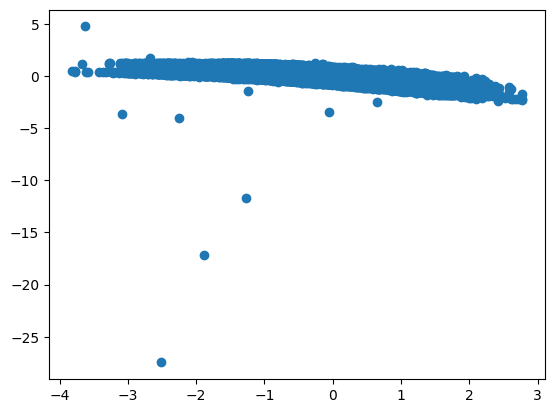

In [67]:
plt.scatter(train['state_t_1'], train['ptend_t_1'])
plt.show

##### **findings from the features:**
- It seems that only some of the air temperature columns affect the every heating tendency feature so if we remove the features that has 0 or close to 0 correlation then the model won't overfit.
- It seems some of the target columns have high correlation between them.
- It looks like the state_v, state_q0001, state_q0002, state_q0003 features might be causing overfitting since the correlation between them are really small.
- It seems like starting from the 27. and also the first 19 of both pbuf_N2O and pbuf_CH4 there is no variance.

In [220]:
gc.collect()

0

##### Testing the findings:

In [30]:
%%time
# testing the first assumption
a = train[:25000, :].to_pandas()

X = a[train_cols]
y = a['ptend_t_0']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = train_model_statsmodels(X_train, y_train)

# Evaluating the model
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)
y_pred = 
r_squared = r2_score(np.expm1(y_test), y_pred)
print("R-squared value:", r_squared)

R-squared value: 0.9614556040741128


In [31]:
del model
gc.collect()

1390

In [37]:
%%time
# testing the first assumption
X = a[assumption_test_1]
y = a['ptend_t_0']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = train_model_statsmodels(X_train, y_train)

# Evaluating the model
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)
r_squared = r2_score(np.expm1(y_test), y_pred)
print("R-squared value:", r_squared)

R-squared value: 0.9590891267807321


In [38]:
del model
gc.collect()

20

Looks like the first assumption was not correct. The reason that the score was worse is probably becaus the removed features have high correlation with the other training columns affecting each other.

In [39]:
%%time
# Testing the second assumption
X = a[train_cols]
y = a['ptend_t_8']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = train_model_statsmodels(X_train, y_train)

# Evaluating the model
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)
r_squared = r2_score(np.expm1(y_test), y_pred)
print("R-squared value:", r_squared)

R-squared value: 0.9922797153482305


In [40]:
del model
gc.collect()

0

In [42]:
%%time
X = a[train_cols + ['ptend_t_7', 'ptend_t_9']]
y = a['ptend_t_8']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = train_model_statsmodels(X_train, y_train)

# Evaluating the model
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)
r_squared = r2_score(np.expm1(y_test), y_pred)
print("R-squared value:", r_squared)

R-squared value: 0.9999093537818008


It seems adding the target columns that have a high correlation with the one we are trying to predicts have a positive effect but the problem with this is that it requires we predict the other features correclty otherwise the effect of using the predicitons would be catastrophic.

## Normalizing the Data

In [ ]:
scaler = RobustScaler()

# Fit the scaler to the data
scaler.fit(train[train_cols])

# Transform the data
train[train_cols] = scaler.transform(train[train_cols])

In [18]:
gc.collect()

0

# Training

In [ ]:
%%time
a = train.to_pandas()

X = a[train_cols]
y = a[pred_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#X = sm.add_constant(X)

models = {}

In [ ]:
"""
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(fit_model, column): column for column in y.columns}
    for future in as_completed(futures):
        target, model = future.result()
        models[target] = model
"""

In [ ]:
%%time
# Parallel processing to fit the models
models = Parallel(n_jobs=-1)(delayed(fit_xgb_model)(y_train[column], y_test[column], X_train, X_test) for column in y.columns)

In [ ]:
try:
    del train, X, y, a, X_train, X_test, y_train, y_test
except:
    None

In [ ]:
gc.collect()

# Predicting

In [ ]:
%%time
weights = submission.iloc[0, 1:].values

predictions_file_path = 'chunked_predictions.csv'
if os.path.exists(predictions_file_path):
    os.remove(predictions_file_path)

In [ ]:
%%time
chunk_size = 125000
process_in_parts('test.csv', chunk_size, models, pred_cols, predictions_file_path)
del models, chunk_size

In [ ]:
# Load the intermediate predictions file
all_predictions = pl.read_csv(predictions_file_path, n_threads=4)

gc.collect()

# Apply weights to each prediction
for i, column in enumerate(submission.columns[1:]):
    all_predictions = all_predictions.with_columns(
        (pl.col(column) * weights[i]).alias(column)
    )

gc.collect()

# Save final submission file
all_predictions.write_parquet('submission.csv')